# **Analys The Problem**

Previously on papper "Facial Expression Recognition Methods in the Wild Based on Fusion Feature of Attention Mechanism and LBP (MDPI Sensors 2023 Q2)" authors used a model called ResNet-50 combined CBAM and LBP.

The accuracy took:
- 99.66% on CK+
- 74.23% on FER-2013
- 89.50 on FER-PLUS 
- 88.20 on RAF-DB

**The problem: What if I change the variant of LBP in this method, does it increase the accuracy spesifically for FER-2013 dataset?**

# **About Dataset**

- The paper used 4 dataset include CK+(59 images), FER-2013 (35,887 images), FER-PLUS(31.412 images), RAF-DB (29,672 images)
- CK+ is a controlled dataset and the 3 others datasets are uncontrolled datasets
- Controlled dataset has good lightning and pose but uncontrolled datasets got a random of it

# **Method**

## Paper's Method

- **ResNet-18 + CBAM**

    1. Architecture of ResNet-18:
    
        <img src="../src/Structure-of-a-ResNet-18-architecture.png" alt="Windowing of Feature in Faces" width="350" height="250">

    2. CBAM Architecture:

        <img src="../src/cbam.png" alt="Windowing of Feature in Faces" width="600" height="100">

    3. Authors combine the CBAM module into each block of the ResNet-18 architecture,
    
        Before and After implement the CBAM module:

        <img src="../src/oriblock.png" alt="Windowing of Feature in Faces" width="150" height="200">
        <img src="../src/blocknCbam.png" alt="Windowing of Feature in Faces" width="150" height="200">

- **Local Binary Patterns (LBP)**

    LBP is one of the most generally used texture pattern descriptors for examining local grain features and is regarded as one of the best methods for texture processing, which is widely employed in image processing.

- **RCL-Net Model**

    After combining all the method such as LBP and ResNet-CBAM, this architecture called by **RCL-Net Model**,

    <img src="../src/rcl-net.png" alt="Windowing of Feature in Faces" width="700" height="200">



## Proposed Method

- In planning, switching LBP method in previous architecture with the newest or other variant LBP

# **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# for augmen:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T

# for mixup augmen:
import torch
import random

# mixup from train.py file
import argparse
import os
import sys

# LBP
import cv2

d:\Ando File 4 Kuliah\A SKRIPSI\RISETku\KERJA\CODE\venv\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())

True


# **DATA LOADING**

- Making dataframe:

In [3]:
# Baca file CSV
file_path = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv'  # Ganti dengan lokasi file kamu
df = pd.read_csv(file_path)

- Visualize the data on datatables:

In [4]:
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


- Checking row and column:

In [5]:
df.shape

(28709, 2)

- Checking info of dataset:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


# **PREPROCESSING**

## Resized Image 100 x 100:

- Define function resized:

In [7]:
# Fungsi untuk mengubah string pixel menjadi gambar
def convert_to_image(pixels, size=(48, 48), new_size=(100, 100)):
    # Ubah string pixel menjadi array
    pixel_values = np.array(pixels.split(), dtype=np.uint8)
    
    # Ubah array 1D menjadi array 2D
    image = pixel_values.reshape(size)
    
    # Buat gambar dari array 2D
    img = Image.fromarray(image)
    
    # Ubah ukuran gambar menggunakan LANCZOS untuk kualitas terbaik
    resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    return resized_img

- Processing the resize to all images and saved to new dataframe:

In [8]:
processed_images_df = pd.DataFrame(columns=['emotion', 'resized_pixels']) # DataFrame baru untuk menyimpan gambar yang sudah diproses

# Proses setiap baris di DataFrame asli dengan progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    pixels = row['pixels']
    
    # Konversi pixel menjadi gambar dan resize
    resized_image = convert_to_image(pixels)
    
    # Ubah gambar yang diresize menjadi array 1D untuk disimpan dalam DataFrame
    resized_image_array = np.array(resized_image).flatten()
    
    # Buat DataFrame baru untuk baris ini
    new_row = pd.DataFrame({
        'emotion': [row['emotion']],
        'resized_pixels': [' '.join(resized_image_array.astype(str))]
    })
    
    # Gabungkan baris baru dengan DataFrame yang sudah ada
    processed_images_df = pd.concat([processed_images_df, new_row], ignore_index=True)

Processing Images: 100%|██████████| 28709/28709 [02:01<00:00, 237.20it/s]


- Visualize the new dataframe:

In [9]:
# Tampilkan beberapa baris dari DataFrame baru
processed_images_df.head()

,emotion,resized_pixels
0,0,69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1,0,151 151 151 149 147 148 152 155 153 148 144 13...
2,2,230 232 227 205 173 154 153 166 178 175 154 13...
3,4,23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4,6,6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


- Before Resized 48x48:

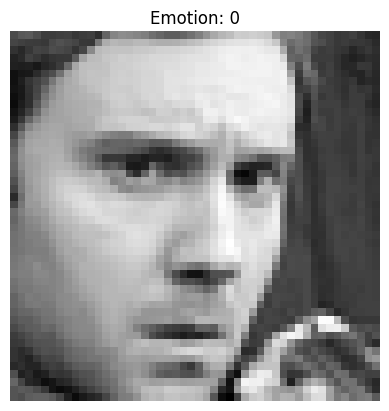

In [10]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = df['pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D
image = pixel_values.reshape(48, 48)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {df['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

- After resized 100x100:

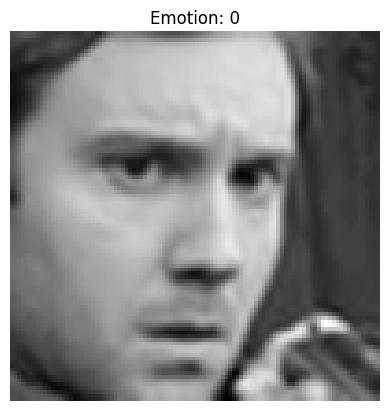

In [11]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # indeks baris yang diinginkan
pixels = processed_images_df['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {processed_images_df['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

## Augmantation

- Define augmentation function:

In [12]:
# Fungsi augmentasi
def augment_image(image):
    # Pipeline augmentasi menggunakan albumentations
    transform = A.Compose([
        A.RandomCrop(width=90, height=90),         # Random crop ukuran 80x80 dari gambar asli (100x100)
        A.HorizontalFlip(p=0.5),                   # Membalik gambar secara horizontal dengan probabilitas 50%
        A.Rotate(limit=20, p=0.5),                 # Memutar gambar dengan sudut hingga 20 derajat
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Jitter warna
        A.CoarseDropout(max_holes=4, max_height=5, max_width=5, p=0.5),  # Random masking
        A.Resize(100, 100),                        # Resize kembali menjadi ukuran 100x100
        # A.Normalize(mean=(0.5,), std=(0.5,)),      # Dibuatr normalize 0,1 agar bentuknya kembali semula kalo ini dihilangkan outputnya pecah, gak jadi ini setelah augmentasi
        ToTensorV2()                               # Ubah gambar menjadi tensor PyTorch
    ])
    
    augmented = transform(image=image)
    return augmented['image']

- Processing the augmentation:

In [13]:
# List untuk menyimpan hasil augmentasi
augmented_images = []
augmented_emotions = []

# Proses augmentasi untuk setiap gambar di dataframe asli
for i in tqdm(range(len(processed_images_df)), desc="Augmenting images"):
    # Ambil gambar dari dataframe dan ubah menjadi array 2D
    pixels = np.array(processed_images_df['resized_pixels'][i].split(), dtype=np.uint8).reshape(100, 100)
    
    # Augmentasi gambar
    augmented_image = augment_image(pixels)
    
    # Ubah tensor augmented_image kembali ke numpy array, lalu ubah jadi string lagi untuk disimpan di dataframe
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy().flatten().tolist()  # Ubah ke list 1D
    augmented_image_str = ' '.join(map(str, augmented_image_np))  # Ubah list jadi string
    
    # Simpan gambar yang sudah di-augmentasi dan emosi ke list
    augmented_images.append(augmented_image_str)
    augmented_emotions.append(processed_images_df['emotion'][i])

# Masukkan hasil augmentasi ke dataframe baru
augmented_df = pd.DataFrame({
    'emotion': augmented_emotions,
    'resized_pixels': augmented_images
})

Augmenting images: 100%|██████████| 28709/28709 [02:36<00:00, 183.57it/s]


In [14]:
augmented_df

,emotion,resized_pixels
0,0,47 52 57 60 60 58 56 55 56 59 62 62 64 67 74 8...
1,0,151 151 150 149 149 150 152 153 151 143 132 12...
2,2,25 30 35 37 37 41 52 68 79 78 71 64 64 69 81 9...
3,4,28 25 27 31 34 36 36 35 32 28 31 33 34 34 33 3...
4,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
28704,2,78 79 79 79 79 79 79 79 79 79 79 80 80 81 81 8...
28705,0,84 85 77 73 79 91 99 98 91 83 74 68 67 70 77 8...
28706,4,105 105 104 105 108 110 111 110 109 107 110 11...
28707,0,255 234 181 127 87 69 70 80 91 93 89 91 94 96 ...


- Visualize image after augmentation:

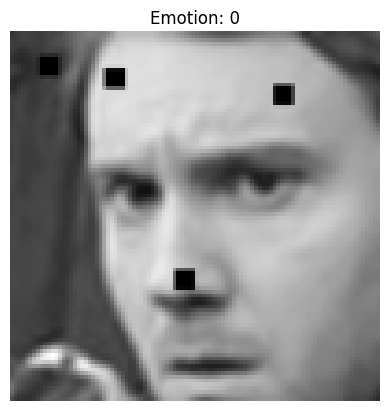

In [15]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = augmented_df['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D (float)
pixel_values = np.array(pixels.split(), dtype=np.float32)

# Denormalisasi dari rentang [-1, 1] ke [0, 255]
# pixel_values = (pixel_values * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Ubah ke tipe data uint8 agar bisa ditampilkan sebagai gambar
image = image.astype(np.uint8)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {augmented_df['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()


- Append the new augmentation into original dataframe before the augmentation:

In [16]:
# Gabungkan dataframe asli dengan dataframe augmented
combined_df = pd.concat([processed_images_df, augmented_df], ignore_index=True)

# Tampilkan informasi jumlah data
print(f"Jumlah data setelah augmentasi: {len(combined_df)}")

# Tampilkan contoh baris dari dataframe gabungan
print(combined_df.head())

Jumlah data setelah augmentasi: 57418
  emotion                                     resized_pixels
0       0  69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1       0  151 151 151 149 147 148 152 155 153 148 144 13...
2       2  230 232 227 205 173 154 153 166 178 175 154 13...
3       4  23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4       6  6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


- Define function normalize pixel to [0,1] dividing by 255:

In [17]:
# Fungsi untuk normalisasi nilai piksel
def normalize_pixels(pixels):
    # Ubah string pixel menjadi array float
    pixel_values = np.array(pixels.split(), dtype=np.float32)
    
    # Bagi setiap nilai piksel dengan 255 untuk menormalisasi ke [0,1]
    normalized_pixel_values = pixel_values / 255.0
    
    # Ubah kembali array menjadi string agar sesuai dengan format dataframe
    return ' '.join(map(str, normalized_pixel_values))

- Proceeding the normalize to all row:

In [18]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
combined_df['resized_pixels'] = combined_df['resized_pixels'].progress_apply(normalize_pixels)

100%|██████████| 57418/57418 [07:49<00:00, 122.42it/s]


- Visualize datatable:

In [19]:
# Tampilkan informasi dataframe setelah normalisasi
combined_df.head()

,emotion,resized_pixels
0,0,0.27058825 0.2784314 0.3019608 0.32941177 0.33...
1,0,0.5921569 0.5921569 0.5921569 0.58431375 0.576...
2,2,0.9019608 0.9098039 0.8901961 0.8039216 0.6784...
3,4,0.09019608 0.09803922 0.10980392 0.13333334 0....
4,6,0.023529412 0.011764706 0.003921569 0.0 0.0 0....


## Mixup Augmentation

- Define function Mixup image and labels:

In [19]:
def mixup_images_labels(images, labels, alpha=0.2):
    """Menerapkan Mixup Augmentation pada dua gambar dan label.
    
    Args:
        images (tensor): Tensor gambar-gambar dengan shape (batch_size, channels, height, width).
        labels (tensor): Tensor one-hot encoded label dengan shape (batch_size, num_classes).
        alpha (float): Parameter distribusi Beta untuk campuran.

    Returns:
        mixed_images: Gambar campuran.
        mixed_labels: Label campuran.
    """
    # Ambil nilai lambda dari distribusi Beta
    lambda_val = np.random.beta(alpha, alpha)
    
    # Pilih dua indeks acak
    index = torch.randperm(images.size(0))
    
    # Gabungkan dua gambar
    mixed_images = lambda_val * images + (1 - lambda_val) * images[index, :]
    
    # Gabungkan label
    mixed_labels = lambda_val * labels + (1 - lambda_val) * labels[index, :]
    
    return mixed_images, mixed_labels


- Define function for data preparation before mixup: 

In [20]:
# Pastikan gambar dalam format tensor dan normalisasi ke [0, 1]
def prepare_images_labels(df):
    images = []
    labels = []

    for i in tqdm(range(len(df))):
        # Ambil pixel dan konversi ke array numpy
        pixels = np.array(df['resized_pixels'][i].split(), dtype=np.float32).reshape(100, 100) / 255.0
        
        # Tambahkan channel dimension untuk tensor (1 channel karena grayscale)
        images.append(pixels[np.newaxis, :, :])
        
        # Ambil label (ekspresi) dan ubah menjadi one-hot encoding
        label = df['emotion'][i]
        one_hot_label = np.zeros(8)  # Misal 8 kelas ekspresi
        one_hot_label[label] = 1
        labels.append(one_hot_label)

    # Ubah list ke tensor
    images = torch.tensor(np.array(images), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    
    return images, labels

In [21]:
# Persiapkan gambar dan label dari combined_df
images, labels = prepare_images_labels(combined_df)

100%|██████████| 57418/57418 [05:53<00:00, 162.48it/s] 


- Processing Mixup Augmentation:

In [22]:
# Batch size untuk Mixup Augmentation
batch_size = 64  # Batch size 64

# Acak gambar dan label untuk setiap batch
for i in tqdm(range(0, len(images), batch_size)):
    batch_images = images[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    
    # Terapkan Mixup Augmentation
    mixed_images, mixed_labels = mixup_images_labels(batch_images, batch_labels, alpha=0.2)

# (Selanjutnya, mixed_images dan mixed_labels dapat digunakan untuk training model)

100%|██████████| 898/898 [00:01<00:00, 801.87it/s]


In [24]:
mixed_images

tensor([[[[0.0010, 0.0012, 0.0013,  ..., 0.0010, 0.0012, 0.0013],
          [0.0010, 0.0011, 0.0012,  ..., 0.0010, 0.0012, 0.0013],
          [0.0010, 0.0011, 0.0012,  ..., 0.0010, 0.0012, 0.0013],
          ...,
          [0.0020, 0.0021, 0.0010,  ..., 0.0010, 0.0009, 0.0008],
          [0.0022, 0.0023, 0.0014,  ..., 0.0010, 0.0009, 0.0008],
          [0.0024, 0.0024, 0.0024,  ..., 0.0013, 0.0010, 0.0008]]],


        [[[0.0005, 0.0006, 0.0007,  ..., 0.0011, 0.0010, 0.0009],
          [0.0006, 0.0006, 0.0007,  ..., 0.0009, 0.0008, 0.0007],
          [0.0006, 0.0006, 0.0007,  ..., 0.0007, 0.0005, 0.0005],
          ...,
          [0.0022, 0.0026, 0.0029,  ..., 0.0012, 0.0012, 0.0013],
          [0.0022, 0.0026, 0.0028,  ..., 0.0010, 0.0011, 0.0012],
          [0.0022, 0.0026, 0.0028,  ..., 0.0009, 0.0010, 0.0010]]],


        [[[0.0010, 0.0010, 0.0010,  ..., 0.0011, 0.0012, 0.0011],
          [0.0010, 0.0010, 0.0010,  ..., 0.0011, 0.0012, 0.0011],
          [0.0010, 0.0010, 0.0010,  ..

In [23]:
mixed_labels

tensor([[0.0000, 0.0000, 0.4666, 0.0000, 0.0000, 0.0000, 0.5334, 0.0000],
        [0.4666, 0.0000, 0.0000, 0.0000, 0.5334, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5334, 0.0000, 0.4666, 0.0000, 0.0000, 0.0000],
        [0.5334, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4666, 0.0000],
        [0.4666, 0.0000, 0.0000, 0.0000, 0.5334, 0.0000, 0.0000, 0.0000],
        [0.5334, 0.0000, 0.0000, 0.0000, 0.4666, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000]])

- Visualize the result of mixup augmented:

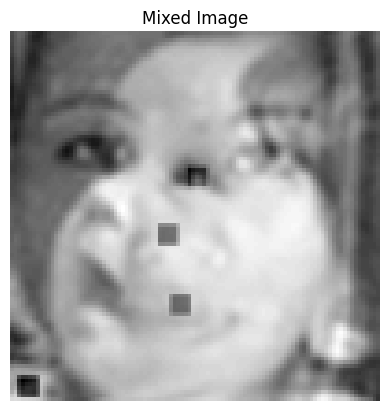

In [32]:
mixed_image = mixed_images[0, 0]  # Ambil gambar pertama dari saluran pertama

# Ubah tensor ke numpy array
image = mixed_image.detach().numpy()  # Mengubah tensor menjadi numpy array

# Denormalisasi jika perlu, misal dari rentang [-1, 1] ke [0, 255]
image = (image * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# Pastikan untuk mengubah tipe data menjadi uint8
image = (image * 255).astype(np.uint8)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hilangkan sumbu
plt.title("Mixed Image")
plt.show()


# MODELING

In [22]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

In [23]:
def lbp_calculated_pixel(img, x, y):
    '''

     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    

    '''    
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top
    
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

In [24]:
def show_output(output_list):
    output_list_len = len(output_list)
    figure = plt.figure()
    for i in range(output_list_len):
        current_dict = output_list[i]
        current_img = current_dict["img"]
        current_xlabel = current_dict["xlabel"]
        current_ylabel = current_dict["ylabel"]
        current_xtick = current_dict["xtick"]
        current_ytick = current_dict["ytick"]
        current_title = current_dict["title"]
        current_type = current_dict["type"]
        current_plot = figure.add_subplot(1, output_list_len, i+1)
        if current_type == "gray":
            current_plot.imshow(current_img, cmap = plt.get_cmap('gray'))
            current_plot.set_title(current_title)
            current_plot.set_xticks(current_xtick)
            current_plot.set_yticks(current_ytick)
            current_plot.set_xlabel(current_xlabel)
            current_plot.set_ylabel(current_ylabel)
        elif current_type == "histogram":
            current_plot.plot(current_img, color = "black")
            current_plot.set_xlim([0,260])
            current_plot.set_title(current_title)
            current_plot.set_xlabel(current_xlabel)
            current_plot.set_ylabel(current_ylabel)            
            ytick_list = [int(i) for i in current_plot.get_yticks()]
            current_plot.set_yticklabels(ytick_list,rotation = 90)

    plt.show()

In [32]:
def main():
    image_file = '../src/lenna.jpg'
    img_bgr = cv2.imread(image_file)
    height, width, channel = img_bgr.shape
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    output_list = []
    output_list.append({
        "img": img_gray,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "Gray Image",
        "type": "gray"        
    })
    output_list.append({
        "img": img_lbp,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "LBP Image",
        "type": "gray"
    })    
    output_list.append({
        "img": hist_lbp,
        "xlabel": "Bins",
        "ylabel": "Number of pixels",
        "xtick": None,
        "ytick": None,
        "title": "Histogram(LBP)",
        "type": "histogram"
    })

    show_output(output_list)
                             
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print("LBP Program is finished")
    print(img_lbp)
    return img_lbp

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10636\2373151931.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  current_plot.set_yticklabels(ytick_list,rotation = 90)


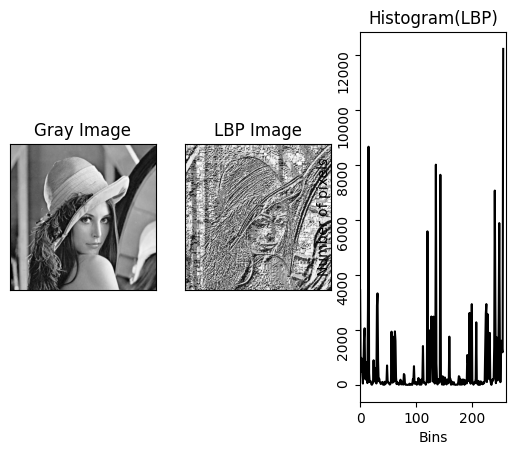

LBP Program is finished
[[[ 14  14  14]
  [ 56  56  56]
  [ 62  62  62]
  ...
  [  0   0   0]
  [ 48  48  48]
  [ 48  48  48]]

 [[  8   8   8]
  [248 248 248]
  [120 120 120]
  ...
  [216 216 216]
  [248 248 248]
  [248 248 248]]

 [[136 136 136]
  [248 248 248]
  [248 248 248]
  ...
  [  0   0   0]
  [112 112 112]
  [112 112 112]]

 ...

 [[247 247 247]
  [207 207 207]
  [143 143 143]
  ...
  [ 28  28  28]
  [ 62  62  62]
  [ 24  24  24]]

 [[247 247 247]
  [135 135 135]
  [ 15  15  15]
  ...
  [ 12  12  12]
  [ 62  62  62]
  [ 24  24  24]]

 [[227 227 227]
  [131 131 131]
  [131 131 131]
  ...
  [  2   2   2]
  [ 34  34  34]
  [  0   0   0]]]


In [36]:
img_lbp = main()

In [37]:
img_lbp

array([[[ 14,  14,  14],
        [ 56,  56,  56],
        [ 62,  62,  62],
        ...,
        [  0,   0,   0],
        [ 48,  48,  48],
        [ 48,  48,  48]],

       [[  8,   8,   8],
        [248, 248, 248],
        [120, 120, 120],
        ...,
        [216, 216, 216],
        [248, 248, 248],
        [248, 248, 248]],

       [[136, 136, 136],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [  0,   0,   0],
        [112, 112, 112],
        [112, 112, 112]],

       ...,

       [[247, 247, 247],
        [207, 207, 207],
        [143, 143, 143],
        ...,
        [ 28,  28,  28],
        [ 62,  62,  62],
        [ 24,  24,  24]],

       [[247, 247, 247],
        [135, 135, 135],
        [ 15,  15,  15],
        ...,
        [ 12,  12,  12],
        [ 62,  62,  62],
        [ 24,  24,  24]],

       [[227, 227, 227],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  2,   2,   2],
        [ 34,  34,  34],
        [  0,   0,   0]]

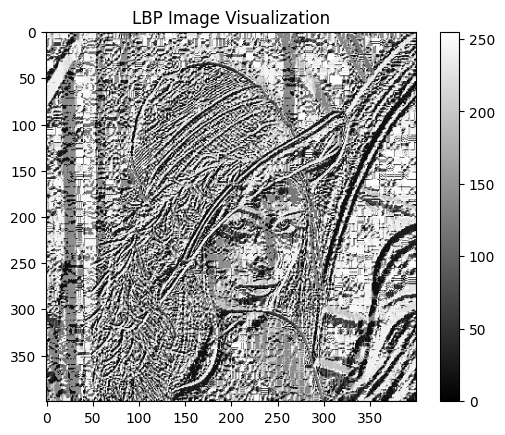

In [40]:
# Pastikan img_lbp hanya memiliki 2 dimensi (grayscale), jika 3D, ambil channel pertama
if img_lbp.ndim == 3:
    img_lbp = img_lbp[:, :, 0]

# Visualisasi gambar menggunakan matplotlib
plt.imshow(img_lbp, cmap='gray')  # cmap='gray' untuk grayscale
plt.colorbar()  # Menambahkan colorbar di samping gambar
plt.title('LBP Image Visualization')
plt.show()

LBP 2

In [41]:
import math

def get_pixel(img, center, x, y, radius, angle):
    # Hitung koordinat tetangga berdasarkan sudut dan radius
    x_new = x + radius * math.cos(angle)
    y_new = y - radius * math.sin(angle)  # Invert Y axis

    # Interpolasi bilinear jika (x_new, y_new) tidak berada pada posisi integer
    x1, y1 = int(math.floor(x_new)), int(math.floor(y_new))
    x2, y2 = int(math.ceil(x_new)), int(math.ceil(y_new))
    
    if x1 >= 0 and y1 >= 0 and x2 < img.shape[0] and y2 < img.shape[1]:
        # Lakukan interpolasi bilinear
        I1 = (x2 - x_new) * img[x1, y1] + (x_new - x1) * img[x2, y1]
        I2 = (x2 - x_new) * img[x1, y2] + (x_new - x1) * img[x2, y2]
        intensity = (y2 - y_new) * I1 + (y_new - y1) * I2
    else:
        intensity = center  # Jika keluar dari batas gambar, set ke nilai pusat
        
    return 1 if intensity >= center else 0


In [42]:
def lbp_calculated_pixel(img, x, y, P=8, R=1):
    center = img[x][y]
    val_ar = []
    
    # Tentukan sudut antara setiap titik tetangga
    for p in range(P):
        angle = 2.0 * math.pi * p / P  # Sudut untuk setiap tetangga
        val_ar.append(get_pixel(img, center, x, y, R, angle))
    
    # Konversi nilai biner ke desimal
    power_val = [2**i for i in range(P)]
    val = sum(val_ar[i] * power_val[i] for i in range(len(val_ar)))
    
    return val


In [46]:
def main():
    image_file = '../src/imagefromsensor.png'
    img_bgr = cv2.imread(image_file)
    height, width, channel = img_bgr.shape
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    img_lbp = np.zeros((height, width), np.uint8)
    
    # Parameter untuk Circular LBP
    P = 8  # Jumlah tetangga
    R = 1  # Radius lingkaran
    
    for i in range(R, height-R):
        for j in range(R, width-R):
            img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j, P, R)
    
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    output_list = []
    output_list.append({
        "img": img_gray,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "Gray Image",
        "type": "gray"        
    })
    output_list.append({
        "img": img_lbp,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "LBP Image",
        "type": "gray"
    })    
    output_list.append({
        "img": hist_lbp,
        "xlabel": "Bins",
        "ylabel": "Number of pixels",
        "xtick": None,
        "ytick": None,
        "title": "Histogram(LBP)",
        "type": "histogram"
    })

    show_output(output_list)
                             
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print("Circular LBP Program is finished")
    return img_lbp


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10636\2373151931.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  current_plot.set_yticklabels(ytick_list,rotation = 90)


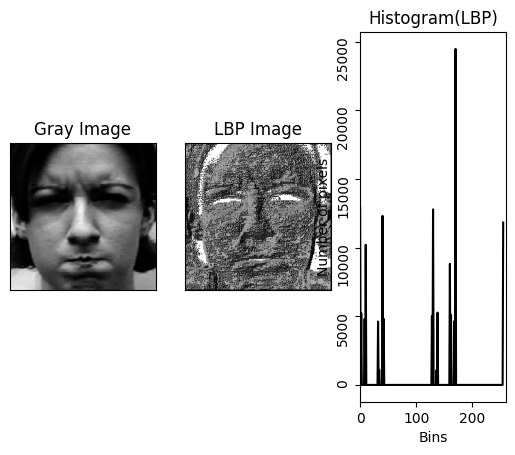

Circular LBP Program is finished


In [47]:
img_lbp = main()

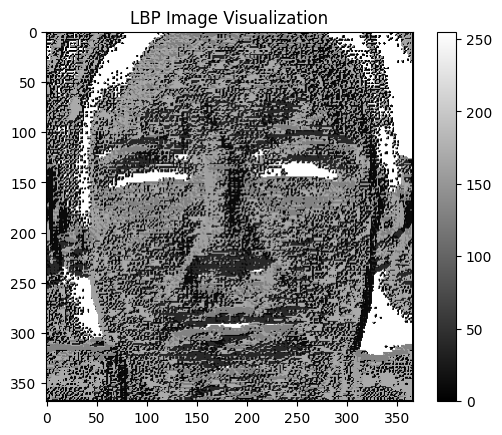

In [48]:
# Pastikan img_lbp hanya memiliki 2 dimensi (grayscale), jika 3D, ambil channel pertama
if img_lbp.ndim == 3:
    img_lbp = img_lbp[:, :, 0]

# Visualisasi gambar menggunakan matplotlib
plt.imshow(img_lbp, cmap='gray')  # cmap='gray' untuk grayscale
plt.colorbar()  # Menambahkan colorbar di samping gambar
plt.title('LBP Image Visualization')
plt.show()

In [60]:
# Buat parser argumen
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')

# Tambahkan argumen yang ingin digunakan
parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
parser.add_argument('--alpha', default=1.0, type=float, help='mixup interpolation coefficient')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')
parser.add_argument('--model', default="ResNet18", type=str,
                    help='model type (default: ResNet18)')
parser.add_argument('--name', default='0', type=str, help='name of run')
parser.add_argument('--seed', default=0, type=int, help='random seed')
parser.add_argument('--batch-size', default=128, type=int, help='batch size')
parser.add_argument('--epoch', default=200, type=int,
                    help='total epochs to run')
parser.add_argument('--no-augment', dest='augment', action='store_false',
                    help='use standard augmentation (default: True)')
parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')

# Filter argumen Jupyter (menghilangkan argumen yang tidak dikenali oleh argparse)
args_to_parse = [arg for arg in sys.argv if arg.startswith('--weight_decay') or arg.startswith('--alpha')]

try:
    # Parsing argumen yang sudah difilter
    args = parser.parse_args(args_to_parse)
    
    # Cetak argumen yang diterima
    print(f'ISI: {args}')
    print(f'Weight Decay: {args.weight_decay}')
    print(f'Alpha: {args.alpha}')
except SystemExit as e:
    print(f"Error parsing arguments: {e}")


ISI: Namespace(weight_decay=0.0001, alpha=1.0, lr=0.1, resume=False, model='ResNet18', name='0', seed=0, batch_size=128, epoch=200, augment=True, decay=0.0001)
Weight Decay: 0.0001
Alpha: 1.0


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = augmented_df['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D (float)
pixel_values = np.array(pixels.split(), dtype=np.float32)

# Ubah array 1D menjadi array 2D (100x100)
pixel_values = pixel_values.reshape(100, 100)

# Tampilkan gambar
plt.imshow(pixel_values, cmap='gray')
plt.axis('off')  # Hilangkan sumbu

# Simpan gambar sebagai JPG atau PNG
plt.savefig('output_image.jpg', bbox_inches='tight', pad_inches=0)  # Menyimpan sebagai JPG
plt.show()  # Tampilkan gambar


NameError: name 'augmented_df' is not defined